In [ ]:
import torch
import matplotlib.pyplot as plt
from fastai2.data.all import *
from fastai2.callback.all import *
from fastai2.learner import Learner
from fastai2.optimizer import SGD

In [ ]:
def func(x):
    return .5-x*x+torch.cos(5*torch.sin(8*x))/2
    

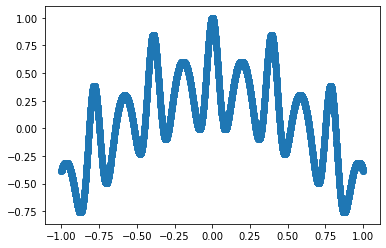

In [313]:
def get_dls(f, bs):
    x = 2 * torch.rand(10000) - 1
    y = func(x)
    plt.scatter(x,y)
    db = DataBlock(get_x = lambda x:x[0], get_y=lambda x:x[1])
    data = torch.stack((x,y),dim=1)
    return db.dataloaders(data,bs=bs, device=torch.device('cpu'))

dls = get_dls(func, 50)

In [308]:
class ShowChart(Callback):
    
    def __init__(self, figsize=(10,10)):
        self.figsize = figsize
        self.dx = torch.linspace(-1,1,1000)
        self.dy = func(self.dx)
    def after_train(self):
        self.update_graph()
    
    
    def begin_fit(self):
        graph_fig, self.graph_ax = plt.subplots(1, figsize=self.figsize)
        plt.close()
        self.graph_out = display(self.graph_ax.figure, display_id=True)
        self.update_graph()
        
    def update_graph(self):
        if not hasattr(self, 'graph_ax'): return
        model = self.learn.model    
        prediction = model(self.dx).detach()
        self.graph_ax.clear()
        self.graph_ax.set_ylim(-1.5,1.5)
        self.graph_ax.plot(self.dx, self.dy, label='actual')
        self.graph_ax.plot(self.dx,prediction, label = 'pred')
        self.graph_ax.legend(loc='lower left');
        self.graph_out.update(self.graph_ax.figure)
       

In [563]:
class BarModule(torch.nn.Module):
    def __init__(self, n):
        super().__init__()
        self.w = nn.Parameter(2 * torch.ones(n) / (n+1))
        #self.c = nn.Parameter(torch.linspace(-1,1,n))
        self.c = nn.Parameter(torch.rand(n) * 2 -1)
        #self.h = nn.Parameter(torch.ones(n)*.5)
        self.h = nn.Parameter(torch.randn(n) / 10)
       
    def forward(self, x):
        x = x[:,None]
        dist = torch.abs(x-self.c) / self.w
        res = 1 - dist.clamp(0,1)
        res = res * self.h
        return torch.sum(res, dim=1) 

In [567]:
bm = BarModule(30)
learn = Learner(dls,bm, loss_func=nn.MSELoss(), cbs = ShowChart)

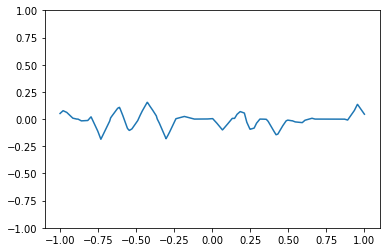

In [568]:
bx = torch.linspace(-1,1,1000)
by = bm(bx).detach()
plt.plot(bx, by)
plt.ylim(-1,1)
plt.show()

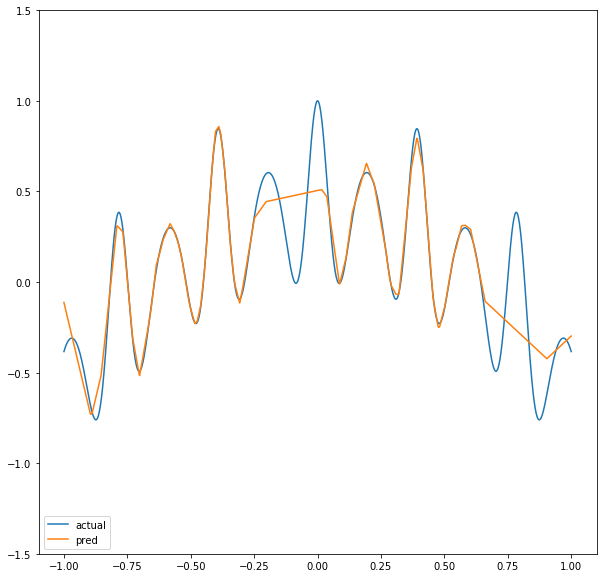

epoch,train_loss,valid_loss,time
0,0.094343,0.080022,00:02
1,0.048824,0.043900,00:02
2,0.033699,0.034296,00:02
3,0.028951,0.031491,00:02


In [ ]:
learn.fit(20, lr=1e-3 )